# A deeper analysis

A more in-depth analysis of all the features in the datasets on musical metrics using decision trees.

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dtreeviz

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as met
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_rows', 2536)
pd.set_option('display.max_columns', 100)

In [27]:
# Loading of the dataset
df = pd.read_csv("./Dati/dataset.csv")
metrics = pd.read_json('./Dati/metrics.json', precise_float=True)

df_feature = ['track_id', 'bit_rate', 'composer', 'duration',  'genre_top', 'listens', 'number']

# Merge the dataframes
df_all = pd.merge(df[df_feature], metrics, on='track_id')

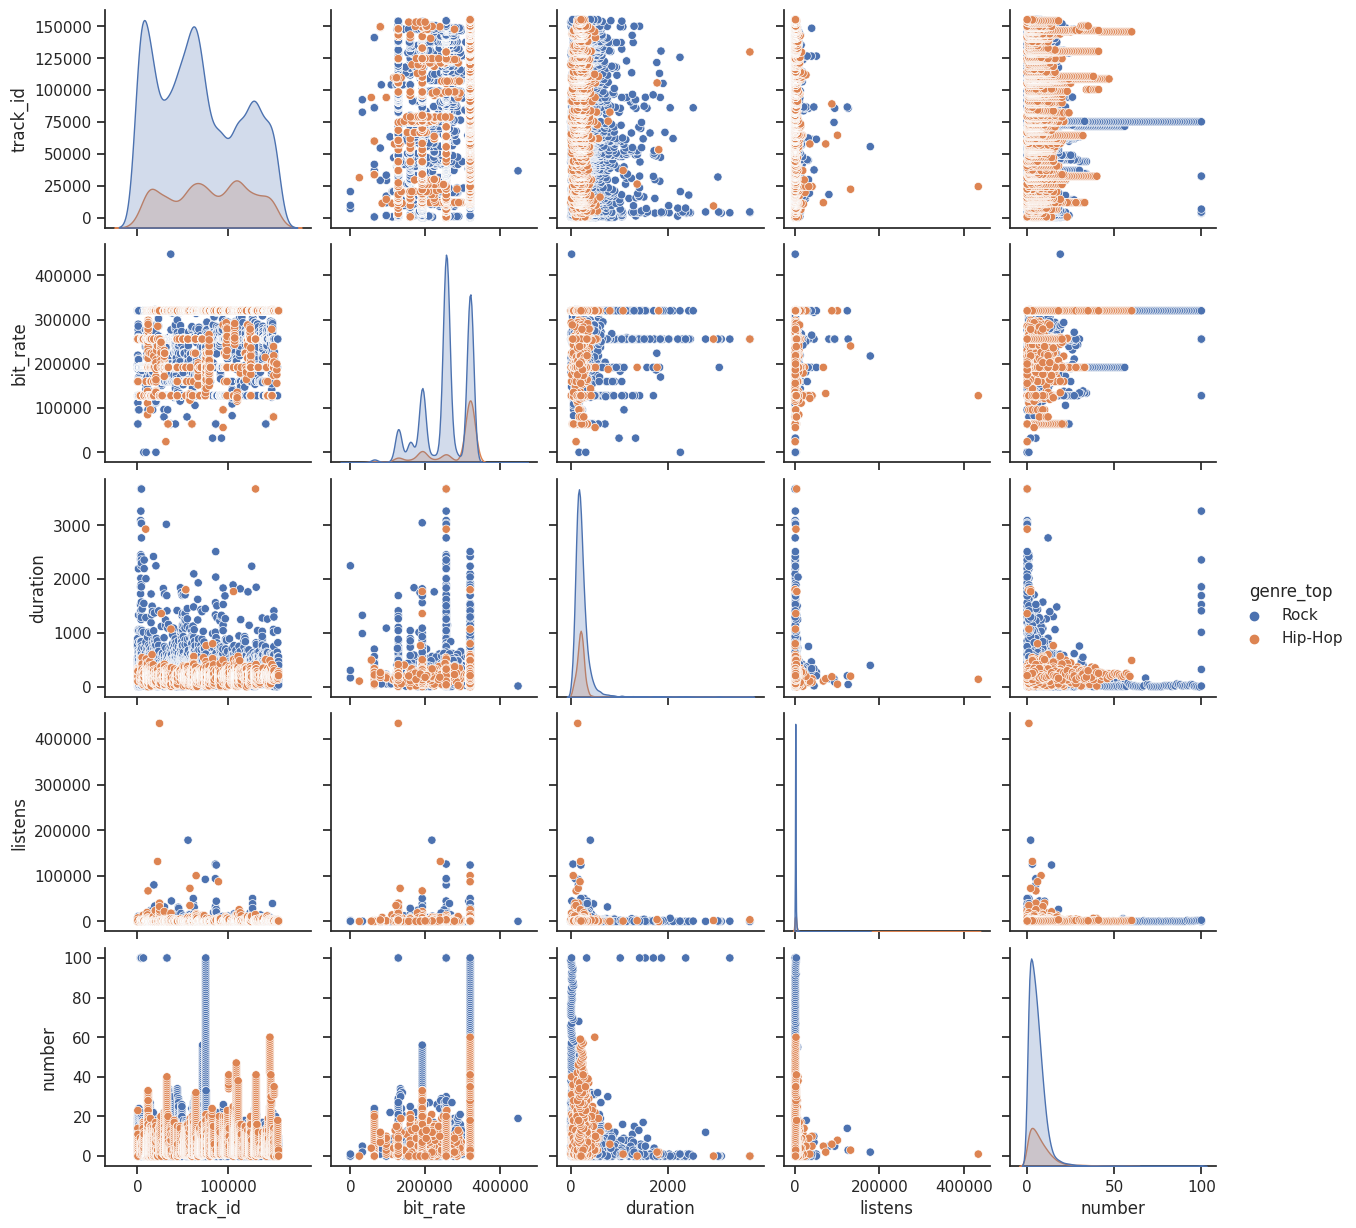

In [28]:
sns.set_theme(style="ticks")
sns.pairplot(df[df_feature], hue="genre_top")

In [29]:
df_all.head()

,track_id,bit_rate,composer,duration,genre_top,listens,number,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,256000,Arc and Sender,405,Rock,424,2,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,256000,Arc and Sender,319,Rock,205,4,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,155,192000,NaN,756,Rock,197,0,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,169,192000,James Squeaky,144,Rock,270,1,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,170,192000,NaN,181,Rock,122,2,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


### Encoding features

Encoding composer adn genre_top.

In [33]:
le = LabelEncoder()

df_all_e = df_all

df_all_e['composer'] = le.fit_transform(df_all['composer'])
df_all_e['genre_top'] = le.fit_transform(df_all['genre_top'])

In [35]:
df_all_e.columns

Index(['track_id', 'bit_rate', 'composer', 'duration', 'genre_top', 'listens',
       'number', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

features = ['bit_rate', 'composer', 'duration', 'listens',
       'number', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence']
target = 'genre_top'

X_train, X_test, y_train, y_test = train_test_split(df_all[features], df_all[target], test_size = 0.3, random_state=1)


In [88]:
# Ottengo un dataframe partendo dal dizionario
# con i valori dei test sulle performance del modello

def dict_to_df(dic):
    df = pd.DataFrame(columns=['type', 'function', 'depth', 'feature', 'value'])

    for f in dic.keys():
        for depth in dic[f].keys():
            for type in list(dic[f][depth].keys())[:2]:
                for feature in dic[f][depth][type].keys():
                    df.loc[len(df)] = [type, f, depth, feature, dic[f][depth][type][feature]]
            
    return df# Faccio i test del modello con i diversi iper-parametri
# e salvo i risultati in un dizionario

In [89]:
# Faccio i test del modello con i diversi iper-parametri
# e salvo i risultati in un dizionario

results = {}

for f in ['entropy', 'gini', 'log_loss']:
    results[f] = dict()

    for depth in range(2, 20):
        tree = DecisionTreeClassifier(criterion=f, max_depth=depth, min_samples_split=2, random_state=1)
        tree = tree.fit(X_train, y_train)

        y_test_pred  = tree.predict(X_test)
        y_train_pred = tree.predict(X_train)

        results[f][depth] = met.classification_report(y_test, y_test_pred, output_dict=True)

In [90]:
#Ottengo il dataframe dal dizionario (con la funzione sopra)

new_df = dict_to_df(results)

new_df = new_df[new_df.feature == 'precision'].drop('feature', axis=1)


# Prendo in considerazione solo i dati sulla precision

new_df_g = new_df.groupby(['function', 'depth']).mean(numeric_only=True).reset_index()

# Prendo i parametri che hanno prodotto una precisione maggiore

s = new_df_g.iloc[new_df_g.loc[:, 'value'].idxmax(), :]
new_df[(new_df.function == s.function) & (new_df.depth == s.depth)]

,type,function,depth,value
24,0,entropy,5,0.817460
28,1,entropy,5,0.937763


In [91]:
# Faccio la predizione con i parametri migliori

tree = DecisionTreeClassifier(criterion=s.function, max_depth=s.depth, min_samples_split=2, random_state=1)

tree.fit(X_train.values, y_train.values)

y_test_pred  = tree.predict(X_test.values)
y_train_pred = tree.predict(X_train.values)

Plot della matrice di confusione

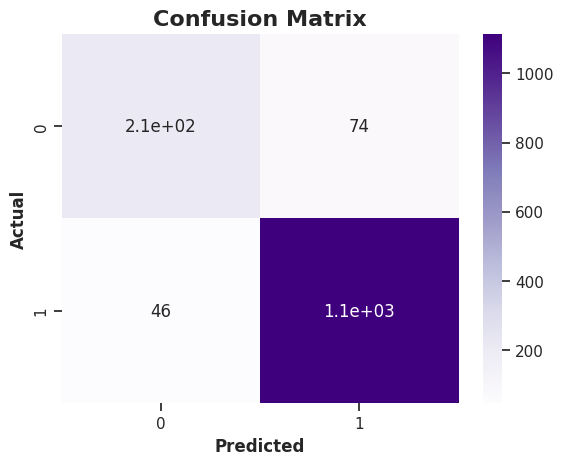

In [92]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples')
plt.title('Confusion Matrix', fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold', fontsize=12)
plt.show();

In [95]:
viz_model = dtreeviz.model(tree,
                           X_train=X_train, y_train=y_train,
                           feature_names=list(X_train.columns),
                           target_name=df_all.columns[-1],
                           class_names=df_all.genre_top.unique())

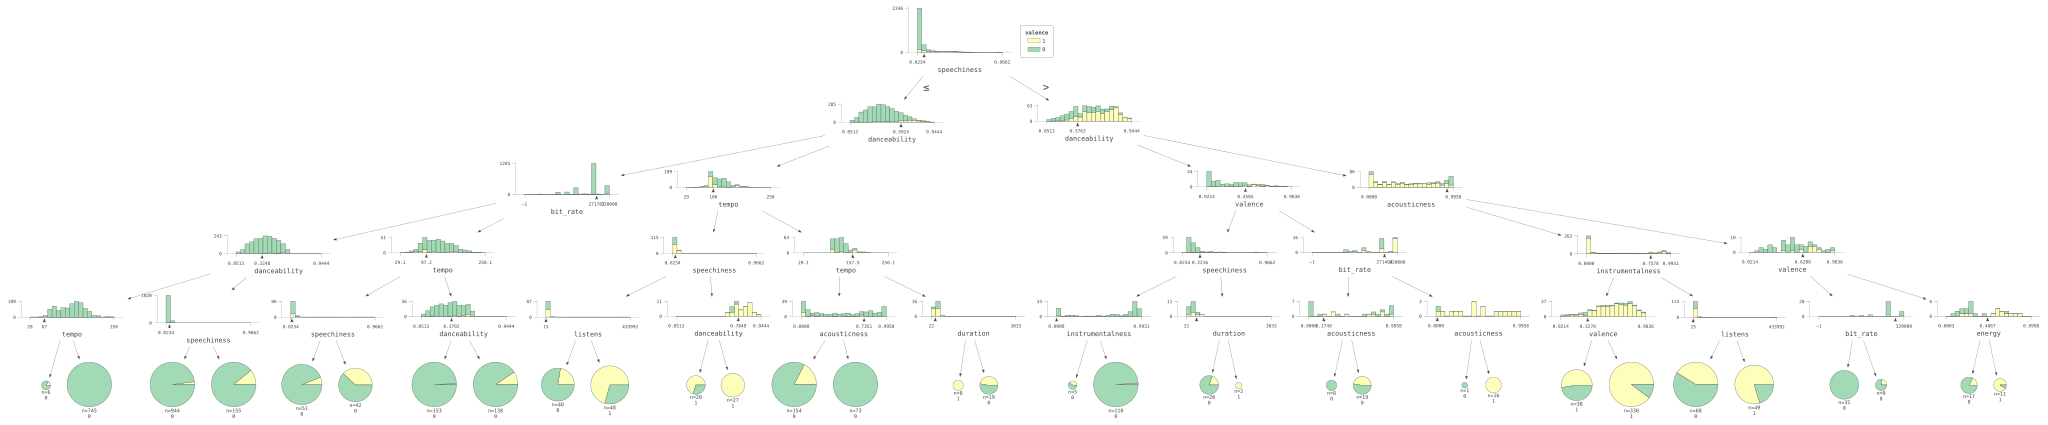

In [96]:
viz_model.view(fontname='monospace')

Calcolo l'accuratezza del modello

In [93]:
print('Accuracy - Test Set: ',  met.accuracy_score(y_test, y_test_pred))
print('Accuracy - Train Set: ', met.accuracy_score(y_train, y_train_pred))

Accuracy - Test Set:  0.9167244968771686
Accuracy - Train Set:  0.9265099672716454


Ottengo metriche aggiuntive di valutazione

In [94]:
print('Report on test set \n', met.classification_report(y_test, y_test_pred))
print('Report on train set\n', met.classification_report(y_train, y_train_pred))

Report on test set 
               precision    recall  f1-score   support

           0       0.82      0.74      0.77       280
           1       0.94      0.96      0.95      1161

    accuracy                           0.92      1441
   macro avg       0.88      0.85      0.86      1441
weighted avg       0.91      0.92      0.92      1441

Report on train set
               precision    recall  f1-score   support

           0       0.85      0.74      0.79       630
           1       0.94      0.97      0.96      2731

    accuracy                           0.93      3361
   macro avg       0.90      0.85      0.87      3361
weighted avg       0.92      0.93      0.92      3361

